In [1]:
import tensorflow as tf
a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

addition = tf.add(a,b)
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print('addition: %i' %sess.run(addition,feed_dict={a: 2, b: 3}))
    
sess.close()

/home/vijayraj/anaconda3/envs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use `tf.global_variables_initializer` instead.
addition: 5


In [2]:
%pylab inline
import os
import numpy as np
import pandas as pd
# from scipy.misc import imread
# from imageio import imread
from PIL import Image
from sklearn.metrics import accuracy_score
import tensorflow as tf




Populating the interactive namespace from numpy and matplotlib


In [3]:
seed  = 128
rng = np.random.RandomState(seed)

root_dir = os.path.abspath('/home/vijayraj/Workspace/Misc')
data_dir = os.path.join(root_dir, 'data')
sub_dir = os.path.join(root_dir, 'sub')

print(os.path.exists(root_dir))
print(os.path.exists(data_dir))
print(os.path.exists(sub_dir))


True
True
True



# sample_sub = pd.r


In [4]:
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.csv'))
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


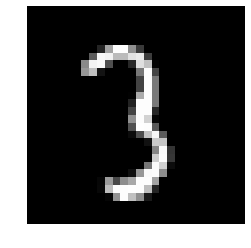

In [5]:
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
img = imread(filepath)
pylab.imshow(img, cmap = 'gray')
pylab.axis('off')
pylab.show()

In [24]:
temp = []
for img_name in train.filename:
    image_path =os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = np.array(Image.open(image_path).convert('L'))
    img = img.astype('float32')
#     print(img.shape)
#     input()
    temp.append(img)
train_x = np.stack(temp)
temp = []
for img_name in test.filename:
    image_path =os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = np.array(Image.open(image_path).convert('L'))
    img = img.astype('float32')
#     print(img.shape)
#     input()
    temp.append(img)
    
test_x = np.stack(temp)

print('test_x shape = ',test_x.shape)
print('train_x shape = ', train_x.shape)

test_x shape =  (21000, 28, 28)
train_x shape =  (49000, 28, 28)


In [25]:
def dense_to_one_hot(labels_dense, num_classes = 10):
    """from class labels to one hot vectors"""
    num_labels  =labels_dense.shape[0]
    index_offset = np.arange(num_labels)*num_classes
    labels_one_hot = np.zeros((num_labels,num_classes))
    labels_one_hot.flat[index_offset+labels_dense.ravel()] = 1
    return labels_one_hot
def preproc(unclean_batch_x):
    """normalize values to 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch
def batch_creater(batch_size, dataset_length, dataset_name):
    """create a dataset batch"""
    batch_mask = rng.choice(dataset_length, batch_size)
#     print(batch_mask.shape)
#     input()
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
#     print('batch_x shape in batch_creator = ', batch_x.shape)
#     input()
    batch_x = preproc(batch_x)
#     print('batch_x shape in batch_creator2 = ', batch_x.shape)
#     input()
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask,'label'].values
        batch_y = dense_to_one_hot(batch_y)
    return batch_x, batch_y

In [26]:
## define neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

x = tf.placeholder(tf.float32, [None,input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

epochs = 5
batch_size = 128
learning_rate = 0.01

## biases and weights of a network
weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units],seed = seed)),
    'output' : tf.Variable(tf.Variable(tf.random_normal([ hidden_num_units,output_num_units], seed=seed))
                          )
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units],seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed =seed))
}

## netork definition
hidden_layer = tf.add(tf.matmul(x, weights['hidden']),biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)
output_layer = tf.matmul(hidden_layer, weights['output'])+ biases['output']


## define cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits =output_layer,labels=y))
# gits(output_layer,y)

#define optimizer
optimzer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.initialize_all_variables()



In [27]:
# CREATE A SESSION
with tf.Session() as sess:
# sess = tf.Session()
    sess.run(init)

    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creater(batch_size,train_x.shape[0], 'train')
    #             print('batch_x shape = ', batch_x.shape, "batch_y.shape= ", batch_y.shape)
            _, c = sess.run([optimzer, cost], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        print("Epoch : ", (epoch+1),"cost = ","{:.5f}".format(avg_cost))
    print("\n Training complete.")

    pred_temp = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp,"float"))
    print("validation Accuracy:", accuracy.eval({x:val_x.reshape(-1,input_num_units), y: dense_to_one_hot(val_y)}))
    predict = tf.argmax(output_layer,1)
    pred = predict.eval({x:test_x.reshape(-1,input_num_units)})
     

/home/vijayraj/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/vijayraj/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch :  1 cost =  9.01698
Epoch :  2 cost =  2.09685
Epoch :  3 cost =  1.19695
Epoch :  4 cost =  0.81379
Epoch :  5 cost =  0.52983

 Training complete.
validation Accuracy: 0.9806122


Prediction is:  3


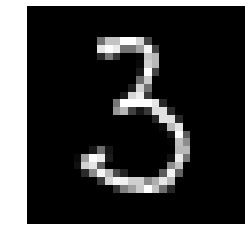

In [42]:
# find predictions val set
img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

# img = imread(filepath, flatten=True)
img = np.array(Image.open(filepath).convert('L'))
test_index = int(img_name.split('.')[0]) - 49000

print("Prediction is: ", pred[test_index])

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()


In [34]:
print(hidden_layer.shape)
print(output_layer.shape)

(?, 500)
(?, 10)


In [ ]:
28*28